# Multi-modal and multi-vendor retina image registration
## Reimplementation by Olivier Morelle

In [3]:


def mean_phase_image(img):
    return img

def center_crop(img, size):
    center = img.shape[0] // 2, img.shape[1] // 2
    
    height_range = center[0] - size[0] // 2, center[0] + size[0] // 2
    width_range = center[1] - size[1] // 2, center[1] + size[1] // 2
    return img[height_range[0]:height_range[1],
               width_range[0]:width_range[1],
               :]
    

In [15]:
import eyepy as ep
import imageio
import matplotlib.pyplot as plt

from skimage.feature import hog, canny, plot_matches
from skimage import exposure

import numpy as np
from PIL import Image

## Read Data, Crop and Resize

In [4]:
with ep.io.VolReader("/home/morelle/data/oct_raw/ExportRAWanonymized/67007_20190515.vol") as reader:
    nir_img = reader.read_nir()
    
cfp_img = imageio.imread("/home/morelle/data/oct_raw/ExportRAWanonymized/HS00+0EZ.003.BMP")
cfp_img = center_crop(cfp_img, (cfp_img.shape[0], cfp_img.shape[0]))


im = Image.fromarray(cfp_img)
im.thumbnail(nir_img.shape, Image.ANTIALIAS)

cfp_img = np.array(im)

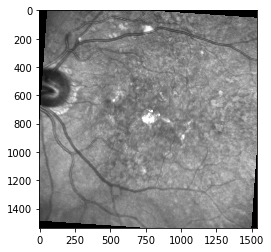

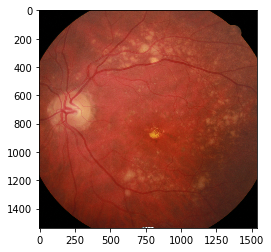

In [5]:
plt.imshow(nir_img, cmap="gray")
plt.show()
plt.imshow(cfp_img, cmap="gray")
plt.show()

## Edge detection

In [696]:
from skimage import feature

In [697]:
edges_nir = canny(nir_img, sigma=1.5)
edges_cfp = canny(cfp_img[..., 1])

In [567]:
nir_img.shape

(1536, 1536)

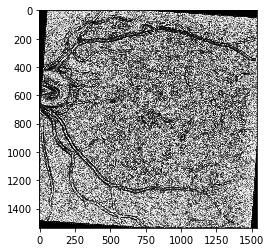

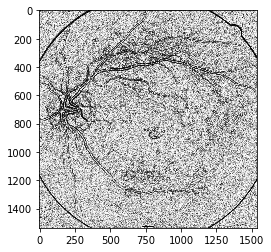

In [572]:
plt.imshow(feature.corner_foerstner(nir_img)[1], cmap="gray")
plt.show()
plt.imshow(feature.corner_foerstner(cfp_img[...,1])[1], cmap="gray")
plt.show()

## Mean phase images

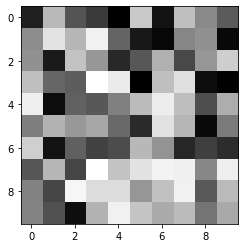

In [272]:
test = np.random.random((10,10))
plt.imshow(test, cmap="gray")

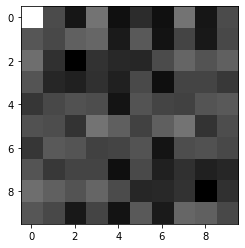

In [273]:
plt.imshow(np.log10(abs(np.fft.fft2(test))), cmap="gray")

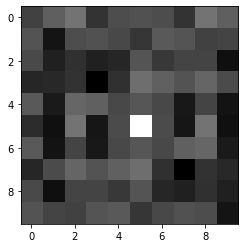

In [274]:
plt.imshow(np.fft.ifftshift(np.log10(abs(np.fft.fft2(test)))), cmap="gray")

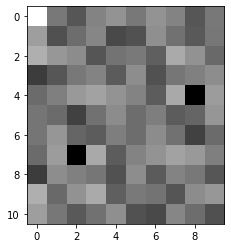

In [262]:
plt.imshow(np.log10(abs(np.fft.fft2(test))), cmap="gray")

In [203]:
np.real(np.fft.fft2(nir_img[:1535, :1535])).min()

-19787091.489047248

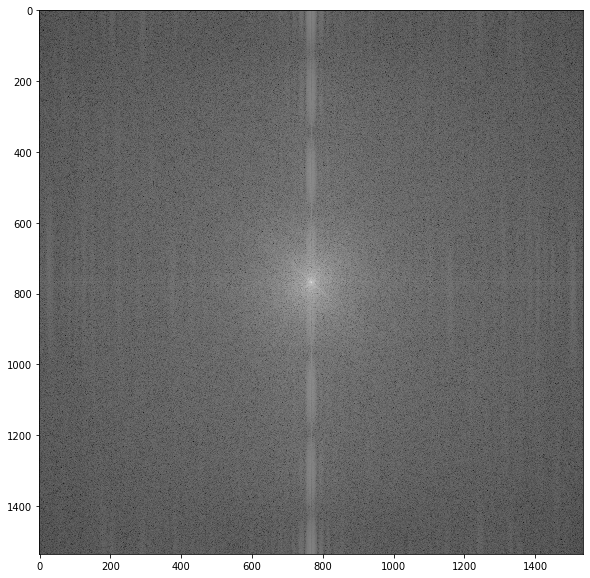

In [241]:
a = 20*np.log10(abs(np.fft.fft2(cfp_img[..., 1])))
#f = np.interp(a, (a.min(), a.max()), (0, 255)).astype(int)
#f = np.interp(f, (f.min(), 20), (0, 255))
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(np.fft.ifftshift(a), cmap="gray")

(array([2.357231e+06, 1.412000e+03, 2.700000e+02, 1.700000e+02,
        8.600000e+01, 5.200000e+01, 1.600000e+01, 1.200000e+01,
        1.000000e+01, 6.000000e+00, 0.000000e+00, 2.000000e+00,
        8.000000e+00, 4.000000e+00, 2.000000e+00, 0.000000e+00,
        2.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.000000e+00, 2.000000e+00, 2.000000e+00,
        0.000000e+00, 0.000000e+00, 4.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 2.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 12

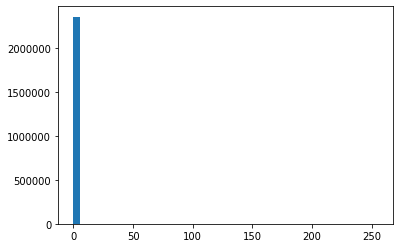

In [220]:
plt.hist(f.flatten(), bins = 50)

In [315]:
def filtergrid(size):
    """ Generates grid for constructing frequency domain filters
    
    Arguments:  rows, cols - Size of image/filter

    Returns:        radius - Grid of size [rows cols] containing normalised
                             radius values from 0 to 0.5.  Grid is quadrant
                             shifted so that 0 frequency is at radius(1,1)
                    u1, u2 - Grids containing normalised frequency values
                             ranging from -0.5 to 0.5 in x and y directions
                             respectively. u1 and u2 are quadrant shifted.
    
    Inspired by filtergrid.m found at https://www.peterkovesi.com/matlabfns/
    """
    
    if type(size) is int:
        rows = cols = size
    
    else:
        rows = size[0]
        cols = size[1]
        
    u1range = np.linspace(-(cols//2), np.floor((cols-1)/2), cols) / cols
    u2range = np.linspace(-(rows//2), np.floor((rows-1)/2), rows) / rows
        
    u1, u2 = np.meshgrid(u1range, u2range)
    
    #Quadrant shift so that filters are constructed with 0 frequency at the corners
    u1 = np.fft.ifftshift(u1)
    u2 = np.fft.ifftshift(u2)
    
    #Construct spatial frequency values in terms of normalised radius from centre.
    radius = np.sqrt(u1**2 + u2**2)
    
    return radius, u1, u2

In [318]:
def lowpassfilter(size, cutoff, order):
    """ Constructs a low-pass butterworth filter.
    
    param size: Two element vector specifying the size of filter to construct [rows cols].
    
    param cutoff: Cutoff frequency of the filter 0 - 0.5
    param order: Order of the filter, the higher n is the sharper the transition is. 
    (n must be an integer >= 1). Note that n is doubled so that it is always an even integer.

    f = 1/ (1 + (w/cutoff))^(2*order)

    The frequency origin of the returned filter is at the corners.
    
    Inspired by lowpassfilter.m found at https://www.peterkovesi.com/matlabfns/
    """
    
    if cutoff < 0 or cutoff > 0.5:
        raise ValueError("The cutoff frequency must be between 0 and 0.5")
        
    if order != int(order) or order < 1:
        raise ValueError("order must be an iteger >= 1")
        
    if type(size) is int:
        rows = cols = size
        
    else:
        rows = size[0]
        cols = size[1]
        
    radius, u1, u2 = filtergrid((rows, cols))
    
    lp_filter = 1.0 / (1.0 + (radius / cutoff)**(2*order))
    
    return lp_filter


#plt.imshow(lowpassfilter((100,100), 0.45, 15))

In [317]:


orientations = [0, 30, 60, 90, 120, 150]
scales = [3,9,27,81]


        

def log_gabor_kernel(frequencies, sigma, angle, freq_domain=False):
    
    # First construct a low-pass filter that is as large as possible, yet falls
    # away to zero at the boundaries.  All log Gabor filters are multiplied by
    # this to ensure no extra frequencies at the 'corners' of the FFT are
    # incorporated as this seems to upset the normalisation process when
    # calculating phase congrunecy.
    
    radius, u1, u2 = filtergrid(frequencies)
    lp = lowpassfilter(frequency,.45,15);  # Radius .45, 'sharpness' 15
    
    # Radial component which controls the frequency band that the filter responds to
    radial = np.exp((-(np.log(radius/frequency))**2) / 
                    (2 * np.log(sigma)**2)) 
    
    # Apply low-pass filter
    radial *= lp 
    # Set the value at the 0 frequency point of the filter 
    # back to zero (undo the radius fudge).
    radial[0,0] = 0
    
    
    # The angular component, which controls the orientation that the filter responds to.
    
    

    
    
def log_gabor(image):
    image_fft = np.fft2(img)
    
    kernel = log_gabor_kernel(freq_domain=True)
    
    #pad kernel with 0
    padded_kernel = np.pad(kernel,
                           ((img.shape[0]-kernel.shape[0])/2, 
                            (img.shape[1]-kernel.shape[1])/2), 
                           mode="constant", constant_values=0)
    
    #shift kernel center to image index (0,0)
    shifted_kernel = np.ifftshift(padded_kernel)
    
    
    
    #apply kernel
    filtered_image = image_fft * shifted_kernel
    
    return np.ifft2(filtered_image)
    
    



In [322]:
from skimage.filters import gabor_kernel

gabor_kernel(3).shape

(3, 3)

In [ ]:
from skimage.filters import gabor_kernel

#cfp_gabor = gabor(cfp_img[..., 1])
#nir_gabor = gabor(nir_img)


def phase(img, frequency=5):
    gabor_real, gabor_imag = gabor(img, frequency)
    return np.arctan(abs(gabor_real)/gabor_imag)

#x = exposure.rescale_intensity(phase(cfp_img[..., 1], 0.5), in_range=(1.6, 1.7))
plt.imshow(phase(cfp_img[..., 1], 0.07), cmap="gray")

In [157]:
np.nanstd(phase(cfp_img[..., 1], 0.5))

/home/morelle/venvs/eyepy/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/morelle/venvs/eyepy/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


4.440892098500626e-16

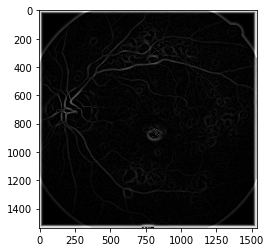

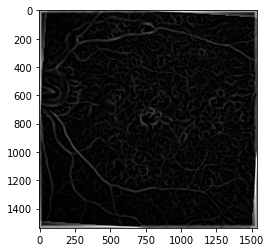

In [6]:
from skimage.filters import meijering

cfp_vessels=meijering(cfp_img[...,1])
nir_vessels=meijering(nir_img)

plt.imshow(cfp_vessels, cmap="gray")
plt.show()
plt.imshow(nir_vessels, cmap="gray")
plt.show()

## Apply HOG on Data

In [7]:
M=16
N=8

fd_nir, nir_hog = hog(nir_vessels, orientations=12, pixels_per_cell=(N, N),
                    cells_per_block=(M, M), visualize=True, multichannel=False, feature_vector=False)


fd_cfp, cfp_hog = hog(cfp_vessels, orientations=12, pixels_per_cell=(N, N),
                    cells_per_block=(M, M), visualize=True, multichannel=False, feature_vector=False)

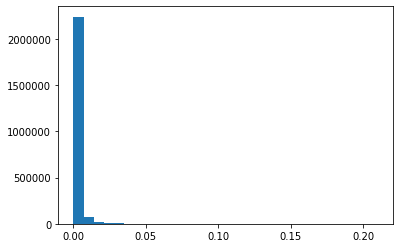

In [8]:
plt.hist(nir_hog.flatten(), bins=30)
plt.show()

(-0.5, 1535.5, 1535.5, -0.5)

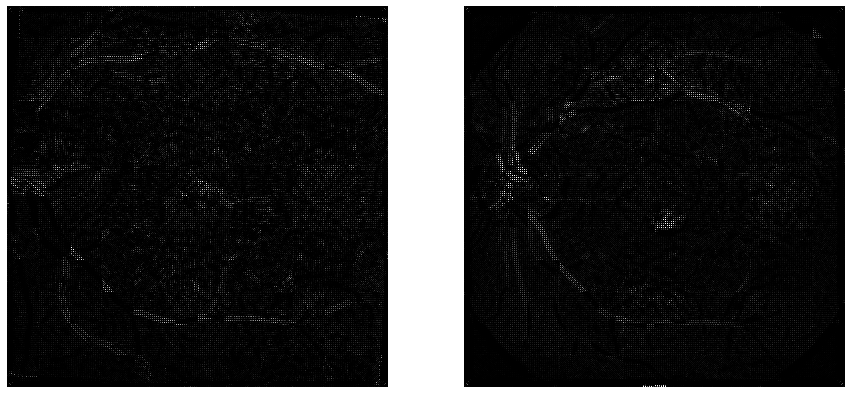

In [9]:
nir_hog_image = exposure.rescale_intensity(nir_hog, in_range=(0, 0.05))
cfp_hog_image = exposure.rescale_intensity(cfp_hog, in_range=(0, 0.05))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))

s = np.s_[...]
ax1.imshow(nir_hog_image[s], cmap="gray")
ax2.imshow(cfp_hog_image[s], cmap="gray")

ax1.axis("off")
ax2.axis("off")

## Match approximate nearest neighbours in hog

Here I used a nearest neighbour approach from sklearn. I could also try to use the annoy package.

In [10]:
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex

def ann(src, dest, n_trees=10):
    t = AnnoyIndex(src.shape[-1], 'angular')  # Length of item vector that will be indexed
    for i in range(src.shape[0]):
        t.add_item(i, src[i])

    t.build(n_trees) # 10 trees
    
    src_1D_indices = np.empty(dest.shape[0], dtype=int)
    src_1D_dist = np.empty(dest.shape[0], dtype=int)
    for i in range(dest.shape[0]):
        ind, dist = t.get_nns_by_vector(dest[i], n=1, search_k=-1, include_distances=True)
        src_1D_indices[i] = ind[0]
        src_1D_dist[i] = dist[0]
    
    return src_1D_indices, src_1D_dist

def mutual_ann_match(src_features, dest_features):
    """
    
    features: ndarray with feature vector on the last axis 
    """  
    
    src_1D_index, src_1D_dist = ann(src_features, dest_features)
    dest_1D_index, dest_1D_dist = ann(dest_features, src_features)
    
    sort_indices = np.argsort(src_1D_dist)
    
    matches = []
    for src_ind, src_val in enumerate([x for x in src_1D_index]):
        dest_val = dest_1D_index[src_val]
        dest_ind = src_val
        
        # Check whether the nearest neighbour of neigh1 at ind
        if src_ind == dest_val and dest_ind == src_val:
            matches.append((src_ind, dest_ind))

    matches = sorted(matches, key=lambda x: src_1D_dist[x[0]] )
    
    return np.array(matches), src_1D_index, dest_1D_index

In [11]:
new_shape_nir = (np.prod(fd_nir.shape[:2]), np.prod(fd_nir.shape[2:]))
new_shape_cfp = (np.prod(fd_cfp.shape[:2]), np.prod(fd_cfp.shape[2:]))
matches, src, dest = mutual_ann_match(fd_cfp.reshape(new_shape_cfp),
                                      fd_nir.reshape(new_shape_nir))

In [12]:
dest_2D = np.array([(x, y) for x, y in zip(*np.unravel_index(dest, fd_nir.shape[:2]))])
src_2D = np.array([(x, y) for x, y in zip(*np.unravel_index(src, fd_cfp.shape[:2]))])

In [13]:
dest_2D = dest_2D*N+(N*M/2)
src_2D = src_2D*N+(N*M/2)

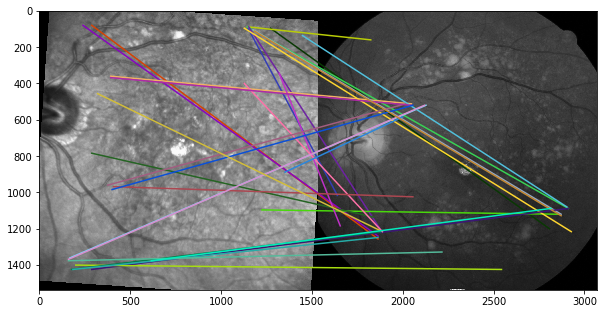

In [134]:
fig, ax = plt.subplots(1,1, figsize=(10,20))
plot_matches(ax, nir_img, cfp_img[..., 1], dest_2D, src_2D, matches[inliers][:30], only_matches=True)

## Use RANSAC for robust estimation of affine transformation

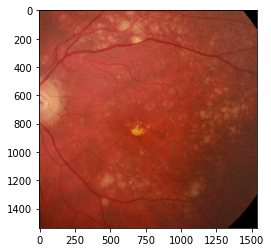

In [132]:
import numpy as np
from matplotlib import pyplot as plt

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac

model_robust, inliers = ransac((src_2D[matches[:, 0]], dest_2D[matches[:, 1]]), AffineTransform, min_samples=3,
                               residual_threshold=15, max_trials=1000)
outliers = inliers == False

transformed_cfp = warp(cfp_img, model_robust.inverse, )#output_shape=nir_img.shape)
plt.imshow((gray2rgb(transformed_cfp*255).astype(int)))

In [129]:
inliers

array([False, False, False, ..., False, False, False])

In [27]:
nir_img.max()

251

In [35]:
transformed_cfp.dtype

dtype('float64')

In [69]:
from skimage.color import gray2rgb
from skimage.segmentation import checkerboard_level_set

In [98]:


def to_rgb_with_alpha(img, channels_last=True, float_scale=True):
    
    if img.min() < 0:
        msg = "Negative values are not allowed in image"
        raise ValueError(msg)
        
    # Integer data should be scaled 0-255
    if img.dtype == int:
        if img.max() > 255:
            msg = "Images of type int have to be scaled 0 to 255"
        
    # Float data should be scaled 0-1
    if img.dtype == float:
        if img.max() > 1.0:
            msg = "Images of type float have to be scaled 0.0 to 1.0"
            raise ValueError(msg)
    
    if float_scale and img.dtype == int:
        img /= 255
        
    if not float_scale and img.dtype == float:
        img = (img*255).astype(int)
        
    
    img = gray2rgb(img, alpha=True)
    return img
        
        

def plot_registration_comparison(img1, img2, square_size=200, figsize=(10,10)):
    fig, ax = plt.subplots(1,1, figsize=figsize)
    
    img1 = to_rgb_with_alpha(img1, float_scale=True)
    img2 = to_rgb_with_alpha(img2, float_scale=True)
    
    alpha = checkerboard_level_set(img1.shape[:-1], square_size).astype(float)
    #alpha[[np.arange(img1.shape[0])],
    #      np.arange(0, img1.shape[1], gridsize[1])] = 1.0
    
    
    #img1[..., -1] = alpha.astype(float)
    img2[..., -1] = alpha#abs(alpha-1)
    ax.imshow(img1)
    ax.imshow(img2)

In [68]:
plt.i

array([0, 2, 4, 6, 8])

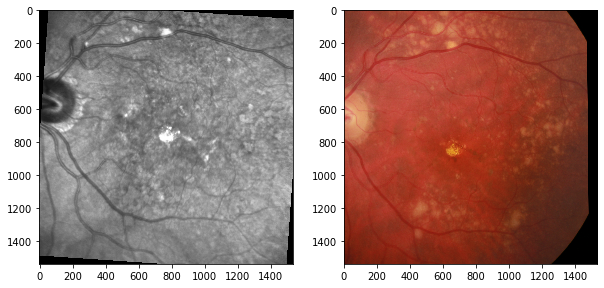

In [125]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,20))
ax1.imshow(nir_img, cmap="gray")
ax2.imshow(transformed_cfp)

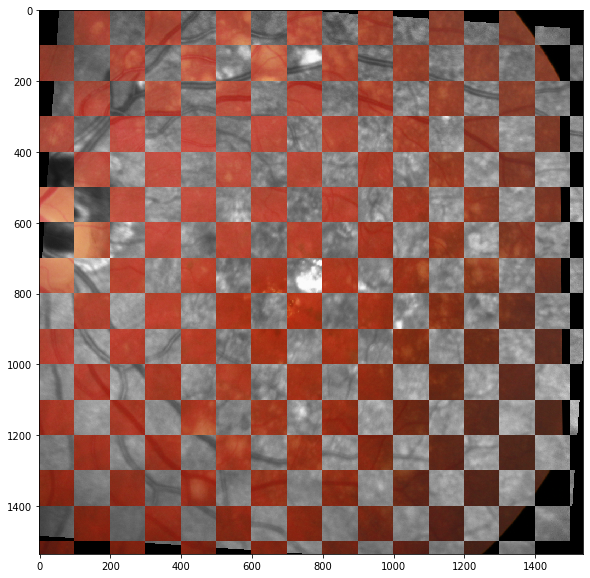

In [128]:
plot_registration_comparison(nir_img, transformed_cfp, square_size=100)

# Example code

Ground truth:
Scale: (0.9000, 0.9000), Translation: (-10.0000, 20.0000), Rotation: -0.2000
Affine transform:
Scale: (0.9015, 0.8913), Translation: (-9.3136, 14.9768), Rotation: -0.1678
RANSAC:
Scale: (0.8999, 0.9001), Translation: (-10.0005, 19.9744), Rotation: -0.1999


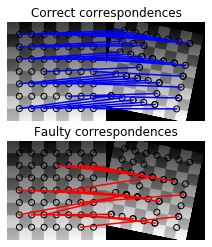

In [169]:
import numpy as np
from matplotlib import pyplot as plt

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac


# generate synthetic checkerboard image and add gradient for the later matching
checkerboard = img_as_float(data.checkerboard())
img_orig = np.zeros(list(checkerboard.shape) + [3])
img_orig[..., 0] = checkerboard
gradient_r, gradient_c = (np.mgrid[0:img_orig.shape[0],
                                   0:img_orig.shape[1]]
                          / float(img_orig.shape[0]))
img_orig[..., 1] = gradient_r
img_orig[..., 2] = gradient_c
img_orig = rescale_intensity(img_orig)
img_orig_gray = rgb2gray(img_orig)

# warp synthetic image
tform = AffineTransform(scale=(0.9, 0.9), rotation=0.2, translation=(20, -10))
img_warped = warp(img_orig, tform.inverse, output_shape=(200, 200))
img_warped_gray = rgb2gray(img_warped)

# extract corners using Harris' corner measure
coords_orig = corner_peaks(corner_harris(img_orig_gray), threshold_rel=0.001,
                           min_distance=5)
coords_warped = corner_peaks(corner_harris(img_warped_gray),
                             threshold_rel=0.001, min_distance=5)

# determine sub-pixel corner position
coords_orig_subpix = corner_subpix(img_orig_gray, coords_orig, window_size=9)
coords_warped_subpix = corner_subpix(img_warped_gray, coords_warped,
                                     window_size=9)


def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g = np.zeros(y.shape, dtype=np.double)
    g[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g /= 2 * np.pi * sigma * sigma
    return g


def match_corner(coord, window_ext=5):
    r, c = np.round(coord).astype(np.intp)
    window_orig = img_orig[r-window_ext:r+window_ext+1,
                           c-window_ext:c+window_ext+1, :]

    # weight pixels depending on distance to center pixel
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))

    # compute sum of squared differences to all corners in warped image
    SSDs = []
    for cr, cc in coords_warped:
        window_warped = img_warped[cr-window_ext:cr+window_ext+1,
                                   cc-window_ext:cc+window_ext+1, :]
        SSD = np.sum(weights * (window_orig - window_warped)**2)
        SSDs.append(SSD)

    # use corner with minimum SSD as correspondence
    min_idx = np.argmin(SSDs)
    return coords_warped_subpix[min_idx]


# find correspondences using simple weighted sum of squared differences
src = []
dst = []
for coord in coords_orig_subpix:
    src.append(coord)
    dst.append(match_corner(coord))
src = np.array(src)
dst = np.array(dst)


# estimate affine transform model using all coordinates
model = AffineTransform()
model.estimate(src, dst)

# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)
outliers = inliers == False


# compare "true" and estimated transform parameters
print("Ground truth:")
print(f"Scale: ({tform.scale[1]:.4f}, {tform.scale[0]:.4f}), "
      f"Translation: ({tform.translation[1]:.4f}, "
      f"{tform.translation[0]:.4f}), "
      f"Rotation: {-tform.rotation:.4f}")
print("Affine transform:")
print(f"Scale: ({model.scale[0]:.4f}, {model.scale[1]:.4f}), "
      f"Translation: ({model.translation[0]:.4f}, "
      f"{model.translation[1]:.4f}), "
      f"Rotation: {model.rotation:.4f}")
print("RANSAC:")
print(f"Scale: ({model_robust.scale[0]:.4f}, {model_robust.scale[1]:.4f}), "
      f"Translation: ({model_robust.translation[0]:.4f}, "
      f"{model_robust.translation[1]:.4f}), "
      f"Rotation: {model_robust.rotation:.4f}")

# visualize correspondence
fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax[0], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
ax[0].axis('off')
ax[0].set_title('Correct correspondences')

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
ax[1].axis('off')
ax[1].set_title('Faulty correspondences')

plt.show()

In [172]:
x

array([], dtype=float64)

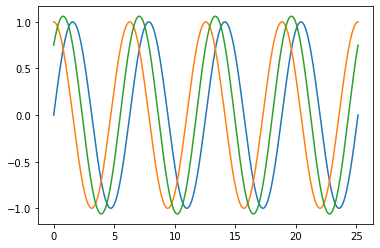

In [181]:
x = np.linspace(0,8*np.pi, 1000)
sin = np.sin(x) #+ np.cos(x)
cos = np.cos(x)
sc = 0.75*sin + .75*cos
plt.plot(x, sin)
plt.plot(x, cos)
plt.plot(x, sc)